In [1]:
# import libraries for time series analysis
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
import logging as log
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")


In [2]:
# # Make class for arima model
# class ArimaModel:
#     def __init__(self, data):
#         self.data = pd.read_csv('./Modified_Data.csv')
#         self.model = None
#         self.order = None
#         self.seasonal_order = None
#         self.forecast = None
#         self.residuals = None
#         self.fitted = None
#         self.rmse = None
#         self.mse = None
#         self.mae = None
#         self.mape = None
#         self.sarimax = None

#     def fit(self, order, seasonal_order):
#         self.order = order
#         self.seasonal_order = seasonal_order
#         self.model = SARIMAX(self.data, order=order, seasonal_order=seasonal_order)
#         self.fitted = self.model.fit()
#         self.forecast = self.fitted.forecast(steps=len(self.data))
#         self.residuals = self.data - self.forecast
#         self.rmse = sqrt(mean_squared_error(self.data, self.forecast))
#         self.mse = mean_squared_error(self.data, self.forecast)
#         self.mae = np.mean(np.abs(self.residuals))
#         self.mape = np.mean(np.abs(self.residuals/self.data))
#         self.sarimax = self.fitted

#     def plot(self):
#         fig = make_subplots(rows=2, cols=1)
#         fig.add_trace(go.Scatter(x=self.data.index, y=self.data, name='Actual'), row=1, col=1)
#         fig.add_trace(go.Scatter(x=self.data.index, y=self.forecast, name='Forecast'), row=1, col=1)
#         fig.add_trace(go.Scatter(x=self.data.index, y=self.residuals, name='Residuals'), row=2, col=1)
#         fig.show()

#     def summary(self):
#         print(self.fitted.summary())

#     def get_forecast(self, steps):
#         return self.fitted.forecast(steps=steps)
    
#     def get_forecast_conf_int(self, steps):
#         return self.fitted.get_forecast(steps=steps).conf_int()
    
#     def get_forecast_index(self, steps):
#         return self.fitted.get_forecast(steps=steps).index
    
#     def get_forecast_summary(self, steps):
#         return self.fitted.get_forecast(steps=steps).summary()
    
#     def get_forecast_results(self, steps):
#         return self.fitted.get_forecast(steps=steps).results
    
#     def get_forecast_residuals(self, steps):
#         return self.fitted.get_forecast(steps=steps).residuals
    
#     def get_forecast_se(self, steps):
#         return self.fitted.get_forecast(steps=steps).se
    
#     def get_forecast_tvalues(self, steps):
#         return self.fitted.get_forecast(steps=steps).tvalues
    
#     def get_forecast_pvalues(self, steps):
#         return self.fitted.get_forecast(steps=steps).pvalues

In [3]:
# Load data from csv file
data = pd.read_csv('../Modified_Data.csv', index_col=[0], parse_dates=True)

In [4]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


In [5]:
# Plot data
fig = px.line(data, x=data.index, y='Price', title='Close Price')
fig.show()

In [6]:
train = data.iloc[:len(data)-48] # 2002 to 2018
test = data.iloc[len(data)-48:] # 2019 to 2022

train.shape, test.shape

((204, 1), (48, 1))

In [7]:
series = pd.Series(data=train['Price'].to_numpy(), index =train.index)
series

2002-01-01    19.96
2002-02-01    20.19
2002-03-01    24.03
2002-04-01    26.03
2002-05-01    25.69
              ...  
2018-08-01    73.85
2018-09-01    79.09
2018-10-01    80.63
2018-11-01    65.96
2018-12-01    57.67
Length: 204, dtype: float64

In [8]:
# adfuller test
from numpy import log
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

adf_test(series)

ADF Statistic: -2.502675
p-value: 0.114825
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


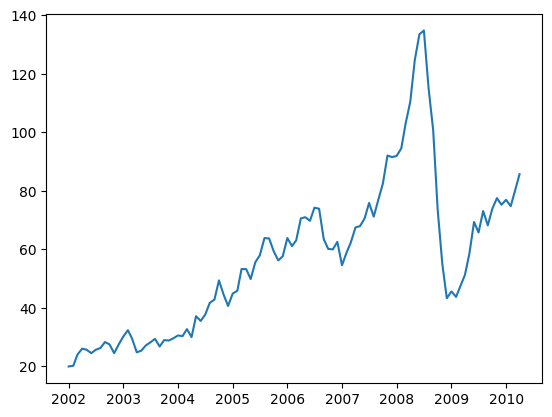

In [9]:
import matplotlib.pyplot as plt
plt.plot(series[0:100])

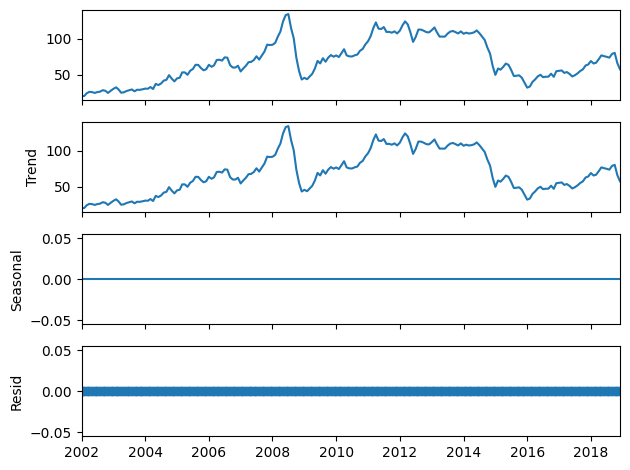

In [10]:
# Decompose time series
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()


In [12]:
# difference data
# from turtle import right
# from matplotlib import legend


diff = series.diff(periods=1).dropna()
diff_2 = diff.diff(periods=1).dropna()

# plot and add legend in top right corner with plotly subplots
fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=diff.index, y=diff, name='1st Difference'), row=1, col=1)
fig.add_trace(go.Scatter(x=diff_2.index, y=diff_2, name='2nd Difference'), row=2, col=1)
fig.add_trace(go.Scatter(x=series.index, y=series, name='Original'), row=3, col=1)
fig.show()




In [13]:
# number of  differencing for stationary series with ndiffs
from pmdarima.arima.utils import ndiffs
y = series
# Adf Test
print('ADF:', ndiffs(y, test='adf'))
# KPSS test
print('KPSS:', ndiffs(y, test='kpss'))
# PP test:
print('PP:', ndiffs(y, test='pp'))



ADF: 1
KPSS: 1
PP: 1


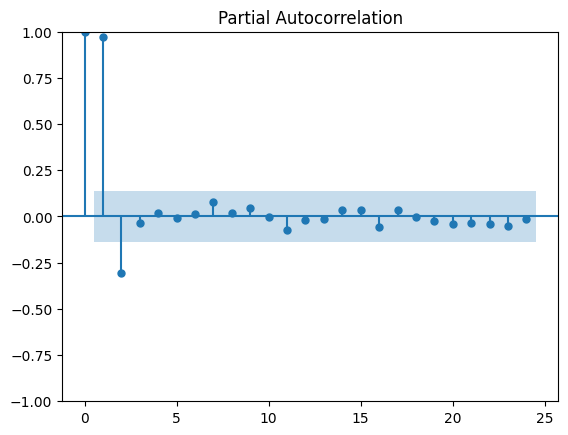

In [14]:
# Order of auto regressive term P
plot_pacf(series).show()

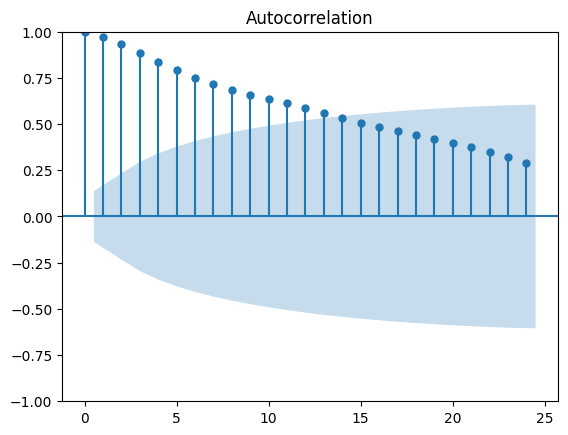

In [15]:
# Find order of MA term Q
plot_acf(series).show()

In [16]:
# use auto_arima to find best parameters
model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True, error_action="ignore")
# model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1256.629, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1290.891, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1254.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1262.100, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1289.102, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1256.781, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1256.796, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1258.338, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1252.888, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1254.840, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1254.855, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1260.226, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1256.393, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.760 seconds


In [17]:
order = model.order 

In [18]:
from statsmodels.tsa.arima_model import ARIMA
# Fit model
model = SARIMAX(series, order=order)
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -624.444
Date:                Sat, 11 May 2024   AIC                           1252.888
Time:                        16:44:09   BIC                           1259.514
Sample:                    01-01-2002   HQIC                          1255.568
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4152      0.047      8.894      0.000       0.324       0.507
sigma2        27.4768      2.023     13.585      0.000      23.513      31.441
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.74
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model = SARIMAX(endog=history, order=order)

horizon = len(test)
model_fit = model.fit()
predictions = model_fit.forecast(steps=horizon)
forecast_period = pd.date_range(start=history.index[-1], periods=horizon+1, freq='MS')[1:]

NameError: name 'history' is not defined

In [ ]:
#%% 

history = data['Price']

predictions = pd.Series(predictions, index=forecast_period)
forecast_90 = model_fit.get_forecast(steps=horizon)
forecast_summary_90 = forecast_90.summary_frame(alpha=0.10)
forecast_95 = model_fit.get_forecast(steps=horizon)
forecast_summary_95 = forecast_95.summary_frame(alpha=0.05)
plt.plot(history.index, history, label='Historical Data')
plt.plot(predictions.index, predictions, color='red', label='Forecasted Values')
plt.fill_between(forecast_summary_90.index,
                    forecast_summary_90['mean_ci_lower'],
                    forecast_summary_90['mean_ci_upper'], color='pink', alpha=0.1, label='90% Confidence Interval')
plt.fill_between(forecast_summary_95.index,
                    forecast_summary_95['mean_ci_lower'],
                    forecast_summary_95['mean_ci_upper'], color='blue', alpha=0.05, label='95% Confidence Interval')
plt.title('Forecast with Confidence Intervals')
plt.legend()
    # plt.savefig('forecast_with_confidence_intervals.png')
#     return predictions, forecast_summary_90, forecast_summary_95
# forecast_future_values(history=data['Price'], order = model.order)

In [20]:
from prophet import Prophet

In [21]:
data = pd.read_csv('../Modified_Data.csv')
data.columns= ['ds','y']

In [22]:
model = Prophet()

In [23]:
model.fit(data)

16:44:13 - cmdstanpy - INFO - Chain [1] start processing


16:44:14 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model.make_future_dataframe(periods=48, freq='MS')

<Figure size 1000x600 with 0 Axes>

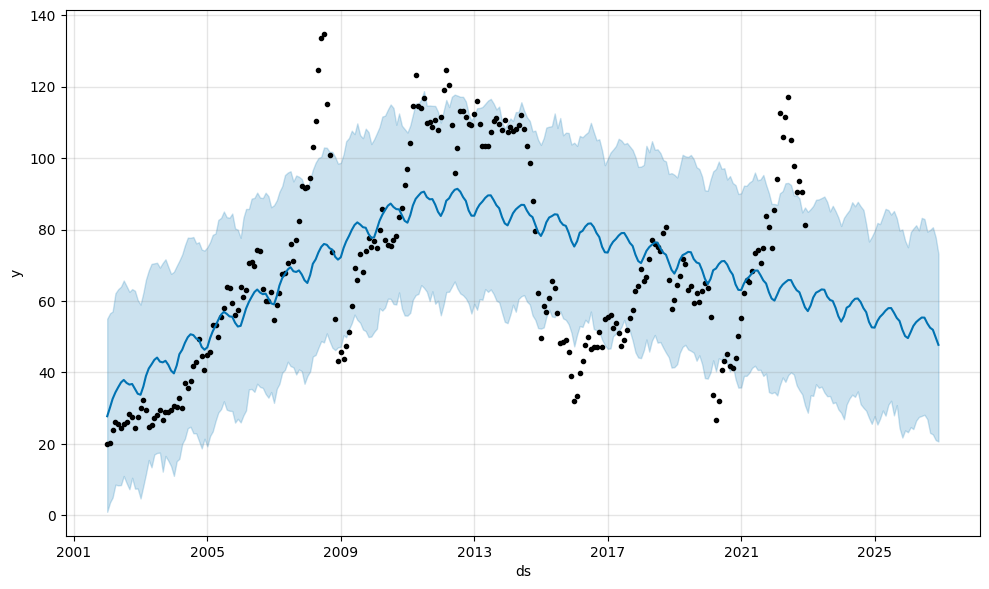

In [25]:
plt.figure(figsize=(10,6))
model.plot(model.predict(future))
plt.show()